The University of Melbourne, School of Computing and Information Systems

# COMP30027 Machine Learning, 2021 Semester 1

## Assignment 1: Pose classification with naive Bayes


**Student ID(s):**     1079686
                       1080915


In [124]:
# import required libraries
import numpy as np
import pandas as pd
from scipy.stats import norm

In [125]:
# function that read in and clean the data for it to be used for later training and testing
def preprocess(filename):
    # read in the file
    data = pd.read_csv(filename, header = None)
    
    # delete the rows that with all freatures unkonwn 
    data = data[data.iloc[:, 1:].mean(axis=1)!=9999]
    
    #replace the unknown value with NaN
    clean_data = data.replace(9999, np.nan)
    return clean_data

In [126]:
# This function calculate prior probabilities and likelihoods from the training data and using them to build a naive Bayes model
def train(train_set):
    # get the prior for each labels
    prior = train_set[0].value_counts() / len(train_set)
    labels = list(prior.keys())
    
    # calculate the mean and std of each class
    mean = {}
    std = {}
    for label in labels:
        mean[label] = list(train_set[train_set[0] == label].describe().loc['mean'])
        std[label] = list(train_set[train_set[0] == label].describe().loc['std'])
    
    # put the prior, mean and std of each class into a model
    model = {}
    for label in labels:
        model[label] = {'prior':prior[label], 'mean':mean[label], 'std':std[label]}
    return model

In [127]:
# function tha calculate the pdf of log gaussian distribution
def gaussian(x, mu, sigma):
    # if a data is Nan, let its density be a really small number instead of 0 to avoid potential errors
    if (np.isnan(x)):
        pdf  = 0.0
    else: 
        pdf = -(x-mu)**2 / (2*sigma**2) - np.log(np.sqrt(2*np.pi*sigma**2))
    return pdf

In [128]:
# This function predicts classes for new items in a test dataset
def predict(test, model):
    predict_labels = []
    labels = list(model.keys())
    
    # iterate every instance of the test dataset
    for j,row in test.iterrows():        
        instance = row[1:]
        scores = []
        
        # Add the log prior value to each class's predicted score
        for label in labels:
            score = np.log(model[label]['prior'])
            
            # Add the prior value with each cell's predicted log gaussian density
            for i, x in enumerate(instance):
                score += gaussian(x, model[label]['mean'][i], model[label]['std'][i])
            scores.append(score)
            
        predict_labels.append(labels[np.argmax(scores)])
        
    # return the class of max score for each instance 
    return predict_labels

In [129]:
# This function evaluate the prediction performance by comparing the model’s class outputs to ground truth labels
def evaluate(test, model):
    true_num = 0
    predict_labels = predict(test, model)
    
    # compare the predicted label with the true labels
    for i, prediction in enumerate(predict_labels):
        true_labels = test.iloc[i, 0]
        if true_labels == predict_labels[i]:
            true_num += 1
            
    return true_num / len(predict_labels) 

In [130]:
# implement the functions on train.csv and test.csv
train_set = preprocess('train.csv')
test = preprocess('test.csv')

model = train(train_set)
accuracy_test = evaluate(test, model)
accuracy_train = evaluate(train_set, model)
print(accuracy_test)
print(accuracy_train)

0.75
0.755464480874317


In [131]:
# export the predicted result to a csv file
prediction = pd.DataFrame(predict(test, model))
prediction.to_csv('result.csv', index=False, header = False)

## Questions 


If you are in a group of 1, you will respond to **two** questions of your choosing.

If you are in a group of 2, you will respond to **four** questions of your choosing.

A response to a question should take about 100–250 words, and make reference to the data wherever possible.

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer should be submitted separately as a PDF.

### Q1
Since this is a multiclass classification problem, there are multiple ways to compute precision, recall, and F-score for this classifier. Implement at least two of the methods from the "Model Evaluation" lecture and discuss any differences between them. (The implementation should be your own and should not just call a pre-existing function.)

In [132]:
# Here use the train data as the training and testing set
predict_train = predict(train_set, model)

# find the confusion matrix
confusion_matrix = pd.crosstab(train_set[0], np.array(predict_train))
# the true positive values are on the diagonal of the confusion matrix
tp = np.diag(confusion_matrix)

# Micro-average precision, recall and f1-score
# Both Micro precision and recall just equals to the accuracy
micro = tp.sum() / confusion_matrix.sum(axis=0).sum()
micro_f1 = 2 * (micro * micro) / (micro + micro)
print('micro precision: ', micro)
print('micro recall: ', micro)
print('micro f1: ', micro_f1)

# Macro-average precision, recall and f1-score
precision = tp / confusion_matrix.sum(axis=0)
precision_mean = precision.mean()
recall = tp / confusion_matrix.sum(axis=1)
recall_mean = recall.mean()
macro_f1 = 2 * (precision_mean * recall_mean) / (precision_mean + recall_mean)

print('macro precision', precision_mean)
print('macro recall', recall_mean)
print('macro f1:', macro_f1)

micro precision:  0.755464480874317
micro recall:  0.755464480874317
micro f1:  0.755464480874317
macro precision 0.7484599594978351
macro recall 0.7284203520960367
macro f1: 0.7383041983122076


I have computed the Micro-average and Macro-average precision/recall of the train dataset. Since the precision and recall of the micro-averaging are both divide by all values in the confusion matrix, they are the same which is 0.755, the micro f1 score is 0.755. On the other hand, macro-averaging precision is 0.748, recall if 0.728 and macro f1 score is 0.738. The Micro precision, recall and f1 are all higher than Macro-averaging. 
Whlist Macro-averaging has different precision and recall, Micro-averaging has the same value, as precision and recall are divided by TP + FP and TP + FN respectively, and they represent different thing as well. For example, we can know that this dataset has more FN than FP from Macro’s precision and recall, but Micro’s does not tell us anything about it. 
The Macro-averaging calculate precision and recall per class and take mean, which means we treated all classes the same. Whereas the Micro-averaging aggregate the contributions of all classes to compute the average precision and recall. Since there do not have extreme imbalance between classes, both Macro and Micro are suitable evaluation. 

### Q2
The Gaussian naıve Bayes classifier assumes that numeric attributes come from a Gaussian distribution. Is this assumption always true for the numeric attributes in this dataset? Identify some cases where the Gaussian assumption is violated and describe any evidence (or lack thereof) that this has some effect on the classifier’s predictions.

Choose some datasets to see if the numeric attributes follow Gaussian distribution. From the confusion matrix, we can see that there are few FP values for class "bridge", "childs", "downwarddog" and "tree". Therefore, these classes might not satisfy with Gaussian distribution.

In [133]:
import matplotlib.pyplot as plt

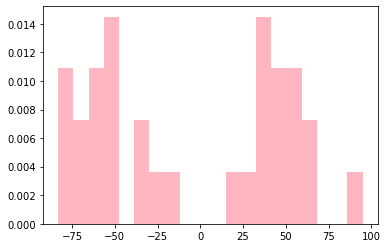

In [134]:
# choose a set of keypoints in class childs and draw its distribution
dataset = train_set.loc[train_set[0]=='childs', 1]
plt.hist(dataset, bins = 20, density = True, color = 'lightpink')
plt.show()

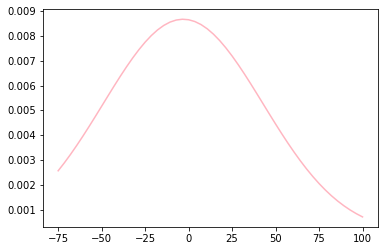

In [135]:
# draw the linear polt of gaussian distribution for this dataset using the mean and std
mean = model['childs']['mean'][1]
std = model['childs']['std'][1]
x = np.linspace(-75, 100)
plt.plot(x, norm.pdf(x, mean, std), 'lightpink')

Here I select keypoint 1 of childs class, plot all datapoints into a histogram(plot 1) and plot a graph of the standard gaussian distribution in that range(plot 2). It is obvious that this histogram was different from the gaussian distribution plot and maybe a bimodel distibution as it have two peaks and a gap in the middle, where gaussian distribution should have only one peak. That explains why the accuracy of "childs" was low. Since the majority of the this keypoint was around -50 or 50 but the prediction tells the classifier that this keypoint should be about 0. If the datapoint is at -75, it might give this point a low score and not recognise it belongs to this class since it is far away from the mean. It misleading the classifier and might result in wrong prediction.

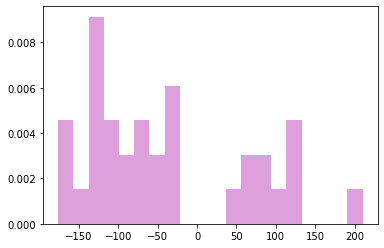

In [136]:
# choose a set of keypoints in class downwarddog and draw its distribution
dataset = train_set.loc[train_set[0]=='downwarddog', 6]
plt.hist(dataset, bins = 20, density = True, color = 'plum')
plt.show()

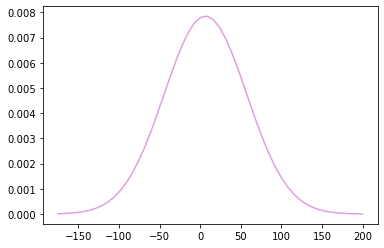

In [137]:
# draw the linear polt of gaussian distribution for this dataset using the mean and std
mean = model['downwarddog']['mean'][6]
std = model['downwarddog']['std'][6]
x = np.linspace(-175, 200)
plt.plot(x, norm.pdf(x, mean, std), 'plum')

In the second case, I chose the 6 keypoints of "downwarddog". I perform the same action on this dataset as the previous one. However, this time we can see that the shape of the histogram was skewed to the left a lot with a gap in the middle, which clearly does not match with its gaussian distribution graph. As this dataset was not even spread as the gaussian distribution, the standard deviation cannot describe the spread well, thus the mean is also not reliable as most of the datapoints clustered on the small end, but the mean is in the middle where no datapoints present.

In addition, not only one single keypoint in these classes does not follow gaussian, I acutally found that most of the keypoints in these classes have similar issues. So we might need to choose other classifiers for these classes to obtain better results. 

### Q3
Implement a kernel density estimate (KDE) naive Bayes classifier and compare its performance to the Gaussian naive Bayes classifier. Recall that KDE has kernel bandwidth as a free parameter -- you can choose an arbitrary value for this, but a value in the range 5-25 is recommended. Discuss any differences you observe between the Gaussian and KDE naive Bayes classifiers. (As with the Gaussian naive Bayes, this KDE naive Bayes implementation should be your own and should not just call a pre-existing function.)

In [138]:
# function that read in and clean the data for it to be used for later training and testing
def preprocess(filename):
    # read in the file
    data = pd.read_csv(filename, header = None)
    
    # delete the rows that with all freatures unkonwn 
    data = data[data.iloc[:, 1:].mean(axis=1)!=9999]
    
    #replace the unknown value with NaN
    clean_data = data.replace(9999, np.nan)
    
    return clean_data

In [139]:
# function that calculate prior and likelihoods of data and using them to build a KDE naive Bayes model
def train_kde(train):
    prior = train[0].value_counts() / len(train)
    labels = list(prior.keys())        
    model_kde = {}
    
    # store the prior and all the instances that have the same label in a dict
    for label in labels:
        model_kde[label] = {'prior':prior[label], 'x':[]}
        group = train[train[0]==label]
        for i in range(1, len(train.columns)):
            model_kde[label]['x'] = group.transpose()
            
    return model_kde

In [140]:
# function that calculate the pdf of the KDE naive Bayes model
def kde(test_pt, train_values, fold):
    
    # set the pdf to zero if the test piont is nan
    if (np.isnan(test_pt)):
        pdf = 0.0
        
    # replace the nan values in the training set with mean and then calculate the density
    else:
        replaced_train = train_values.replace(np.nan, train_values.mean())
        pdf = np.log(norm.pdf([test_pt - x for x in replaced_train], 0, fold).mean())
        
    return pdf

In [142]:
# function that predicts classes for new items in a test dataset
def predict_kde(test, model, fold):
    predictions = []
    labels = list(model.keys())
    # get each instance in the test to calc their scores
    for j,row in test.iterrows(): 
        instance = row[1:]
        scores = []
        for label in labels:
            score = np.log(model[label]['prior'])
            # calc the density of the feature of the current feature point
            for i, x in enumerate(instance):
                score += kde(x, model[label]['x'].iloc[1:,i], fold)
            scores.append(score)
        # add the label with the highest score
        predictions.append(labels[np.argmax(scores)])
    return predictions

In [143]:
# function that evaluates the prediction performance by comparing the model’s class outputs to ground truth labels
def evaluate_kde(test, model, fold):
    true_num = 0
    predict_labels = predict_kde(test, model, fold)
    
    # compare the predicted label with the true labels
    for i, prediction in enumerate(predict_labels):
        true_labels = test.iloc[i, 0]
        if true_labels == predict_labels[i]:
            true_num += 1
    return true_num / len(predict_labels) 

In [144]:
# preprocess the data set 
train_set = preprocess('train.csv')
test = preprocess('test.csv')

# set an kernel bandwidth as an arbitrary number(5)
arbitrary_k = 5
# train the kde model and then calc the accuracy
model_kde = train_kde(train_set)
accuracy_kde1 = evaluate_kde(test, model_kde, arbitrary_k)
accuracy_kde2 = evaluate_kde(train_set, model_kde, arbitrary_k)
print(accuracy_kde1)
print(accuracy_kde2)

<ipython-input-140-7c70c28030b0>:11: RuntimeWarning: divide by zero encountered in log
  pdf = np.log(norm.pdf([test_pt - x for x in replaced_train], 0, fold).mean())


0.3392857142857143
0.37841530054644806


By calculating the accuracy for the test and train set using KDE Navie Bayes with an arbitrary bandwidth 5, I get an an accuarcy of 0.339(test) and 0.378(train) which is much lower compare with when I am using the GNB where the accuracy is 0.75(test) and 0.755(train). This might because the data is actually normal distributed and hence the Gaussian naive Bayes classifier outperforms the KDE one. 
Factors that might affect our results could be different bandwidths that we arbitrarily chose. For example, if I chose the bandwidth to be 10, it will then get the accuracy of 0.393(test) and 0.452(train). Another factor could be the way that I deal with the missing values. To build the KDE naive Bayes classifier, I chose to replace the missing values with the mean values of the relative feature from the training set. For example, if for a certain yoga pose, a key point is suppose to be covered up(hence nan) but I alter it to be the mean value of the attribute. This could also be a potential cause of the low performance.


### Q4
Instead of using an arbitrary kernel bandwidth for the KDE naive Bayes classifier, use random hold-out or cross-validation to choose the kernel bandwidth. Discuss how this changes the model performance compared to using an arbitrary kernel bandwidth.

In [145]:
# set the kernel bandwidth to list of 5-25 with interval 5
k = [5, 10, 15, 20, 25]

# shuffle the instance in the train set 
shuffle_train = train_set.sample(frac = 1)
mean_result = []

# split the data according to each bandwidthget and get the mean result 
for fold in k:
    fold_result = []
    train_parts = np.array_split(shuffle_train, fold)
    # seperate the folds into test and training set
    for i in range(fold):  
        k_test = train_parts[i]
        temp_list = train_parts[:]
        temp_list.pop(i)
        k_train = pd.concat(temp_list)

        #train the selected parts
        kf_model = train_kde(k_train)

        # evaluate and then keep the result of each folds in a list
        fold_result.append(evaluate_kde(k_test, kf_model, fold))

    # get the mean result for this fold
    mean_result.append(sum(fold_result)/len(fold_result))
mean_result 

<ipython-input-140-7c70c28030b0>:11: RuntimeWarning: divide by zero encountered in log
  pdf = np.log(norm.pdf([test_pt - x for x in replaced_train], 0, fold).mean())


[0.3222905600596403,
 0.28000740466493884,
 0.3141156462585034,
 0.3165165165165165,
 0.3353103448275862]

In [146]:
# get the highest bandwidth
best_k = k[np.argmax(mean_result)]
best_k

25

Here I used cross-validation with the bandwidth to a list of 5-25 with interval 5. By observing the train data, I find that the instances are grouped by their class label. Hence, for better training result, I first shuffle the instances in the train data then split them into train and test set. Like as in Question 3, I chose to replace the missing value in train set as the mean value of the relative attribute. For each bandwidth, I calculate the accuracy of each of its split and hence calculate the mean accuracy of all its splits. Out of all the bandwidths, I then chose the one which have the highest accuracy which is 25 in this case. 
One thing to notice with is that since I shuffle the train data at the start, the accuracy might be different every time I run the program. As one example, I get the mean accuracy of each bandwidth as [0.3360544217687075, 0.3946686412439837, 0.414937641723356, 0.4204579579579579, 0.43586206896551716]. There is a clear growth in the accuracy when the bandwidth gets larger. This result might because larger bandwidth means more times of evaluations, hence might lead to an improvement in the performance of the model. We do not choose larger k since it could be time consuming. By fitting the train data, we can see that the result uses a bandwidth between 10 and 25 have a higher accuracy compare with the result from question 3 where we use 5 as the bandwidth have an accuracy of 0.378. The k-folds validation allows us to make prediction on all the data and hence reduce bias. Next time I could repeat the evaluation of the shuffled train data for several times to improve the reliability of the result as each shuffle could have different result.

